In [2]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)


In [4]:
df = pd.read_csv('data/info.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.6, random_state=None)
# X_test = df.loc[:, df.columns != 'isZoonotic']
# y_test = df['isZoonotic']

In [45]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

curr_dir = 'models/curr_models'
best_xgboost = pickle.load(open(f'{curr_dir}/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open(f'{curr_dir}/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open(f'{curr_dir}/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open(f'{curr_dir}/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open(f'{curr_dir}/randforest.pkl', 'rb'))

lrmodel = pickle.load(open(f'{curr_dir}/lrmodel.pkl', 'rb'))


nardus_gradBoost = pickle.load(open(f'models/nardus_testing/gradBoost.pkl', 'rb'))

cols_when_model_builds = nardus_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print(len(X_test))
print("Best nardus GBM Accuracy: ", accuracy_score(y_test, nardus_gradBoost.predict(X_test)))
print("Balanced nardus GBM Accuracy: ", balanced_accuracy_score(y_test, nardus_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, nardus_gradBoost.predict(X_test)).ravel())



cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())


cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))


print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(    y_test, best_rF.predict(X_test)))
print(confusion_matrix(y_test, best_rF.predict(X_test)).ravel())


print("Best lR Accuracy: ", accuracy_score(y_test, lrmodel.predict(X_test)))
print("Balanced lR Accuracy: ", balanced_accuracy_score(y_test, lrmodel.predict(X_test)))
print(confusion_matrix(y_test, lrmodel.predict(X_test)).ravel())

5658
Best nardus GBM Accuracy:  0.9890420643336868
Balanced nardus GBM Accuracy:  0.9752997201484068
[4889   30   32  707]
Best XG Accuracy:  0.9916931778013433
Balanced XG Accuracy:  0.9733747604288252
[4910    9   46  693]
Best GB Accuracy:  0.9902792506185931
Balanced GB Accuracy:  0.9679620405370797
[4910    9   46  693]
[[4910    9]
 [  46  693]]
Best rF Accuracy:  0.8596677271120537
Balanced rF Accuracy:  0.5007338092250067
[4853   66  728   11]
Best lR Accuracy:  0.9420289855072463
Balanced lR Accuracy:  0.8298233823667363
[4829   90  238  501]


In [46]:
cols_when_model_builds = nardus_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]
print([round(x, 2) for x in nardus_gradBoost.predict_proba(X_test)[:,1][:20]])
print([x for x in y_test[:20]])
print("Best nardus GBM Accuracy: ", accuracy_score(y_test, nardus_gradBoost.predict(X_test)))

[0.0, 0.99, 0.0, 0.01, 0.03, 0.0, 0.83, 0.0, 0.0, 0.86, 0.01, 0.04, 0.01, 0.01, 0.01, 0.98, 0.0, 0.0, 0.01, 0.01]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Best nardus GBM Accuracy:  0.9890420643336868


precision recall: 0.9875113433602021
[0.00402191 0.99463819 0.00194247 ... 0.4653341  0.01460248 0.17909568]


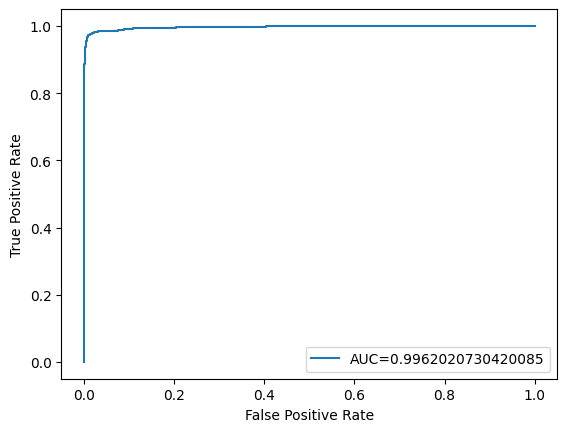

In [47]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = nardus_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, nardus_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = nardus_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

precision recall: 0.9862107652137587
[3.8396047e-05 9.9954563e-01 2.5888337e-04 ... 2.9620866e-03 3.1960085e-03
 3.8658928e-02]


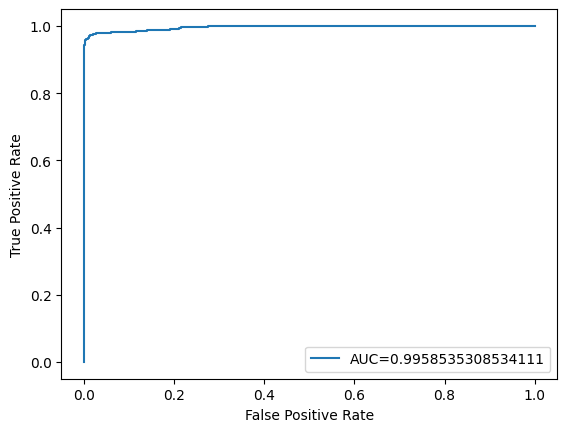

In [14]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

precision recall: 0.9876463852166343
[0.0018779  0.00113596 0.01110198 ... 0.00592477 0.00275894 0.00266834]


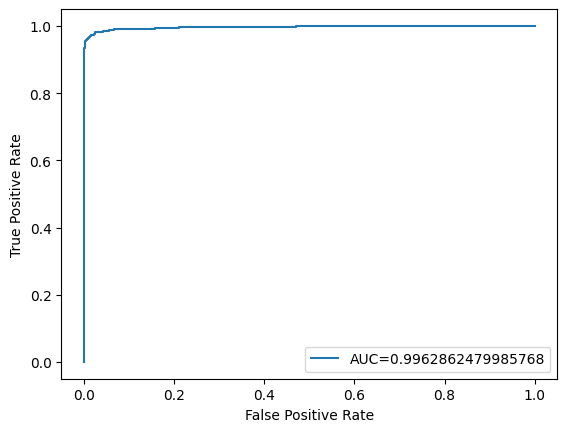

In [5]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [42]:
cols_when_model_builds = nardus_gradBoost.best_estimator_.feature_names_in_
X_test=X_test[cols_when_model_builds]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(nardus_gradBoost.best_estimator_, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.955 (0.008)


In [43]:
cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.958 (0.007)


In [44]:
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.952 (0.009)


In [8]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.920 (0.011)


In [9]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.923 (0.011)


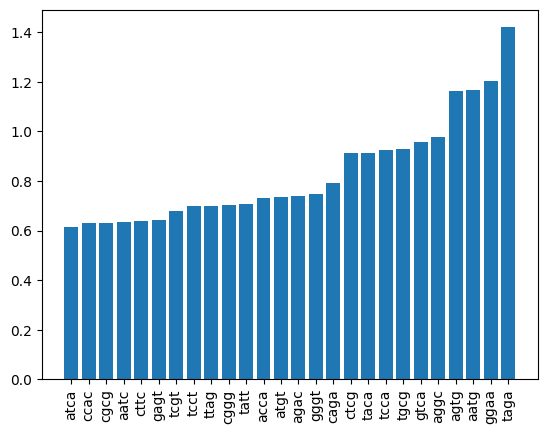

In [13]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in res[230:]], [x[1] for x in res[230:]])
plt.show()

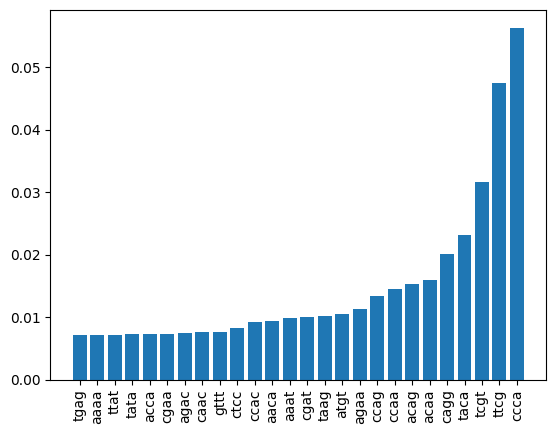

In [12]:
results = best_xgboost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resxG = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resxG[230:]], [x[1] for x in resxG[230:]])
plt.show()

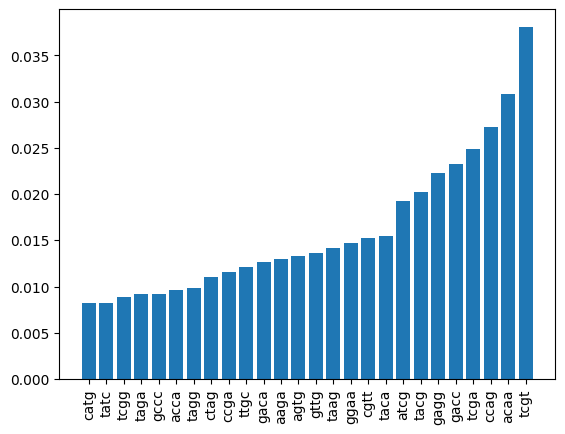

In [15]:
results = best_gradBoost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resgB = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resgB[230:]], [x[1] for x in resgB[230:]])
plt.show()

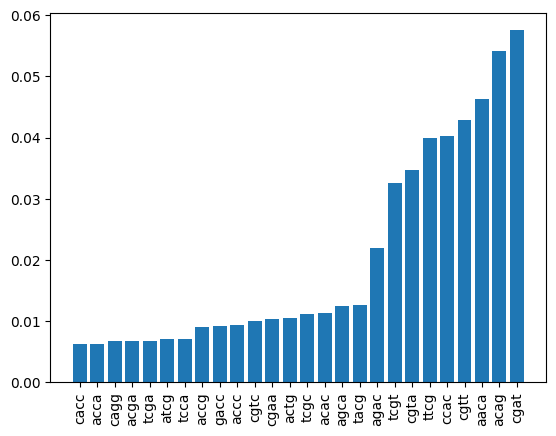

In [16]:
# get feature importances as a mean of feature importances PER tree
results = np.mean([est.steps[1][1].feature_importances_ for est in best_rF.estimators_], axis=0)


l = zip([x for x in X_test.columns.values],results)
l = list(l)
resrF = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resrF[230:]], [x[1] for x in resrF[230:]])
plt.show()

In [18]:
max_bound = 3
for x in range(len(resrF)-max_bound+1):
    for i in range(max_bound):
        if resrF[x][0] == resgB[x+i][0]:  print("rF & gb bound", i, resrF[x], x)
        if resrF[x][0] == resxG[x+i][0]:  print("rF & xg bound", i, resrF[x], x)
        if resgB[x][0] == resxG[x+i][0]:  print("gb & xg bound", i, resgB[x], x)

rF & gb bound 1 ('cgcg', 0.0003015572826893574) 12
rF & xg bound 0 ('cgac', 0.0005925319998248206) 21
rF & gb bound 1 ('tatt', 0.0011150453509348468) 60
rF & gb bound 0 ('ctcg', 0.001601226302398424) 96
rF & xg bound 2 ('taac', 0.0016960808192351047) 105
rF & xg bound 1 ('caaa', 0.0018456698283735272) 115
gb & xg bound 1 ('agct', 0.002219047867503112) 122
rF & xg bound 1 ('ctca', 0.0020714853411268937) 132
rF & gb bound 2 ('gaac', 0.0025670387790062968) 151
gb & xg bound 0 ('taag', 0.014197001200931161) 244
